Device: cuda
GPU: Tesla T4


100%|██████████| 170M/170M [00:01<00:00, 95.9MB/s] 


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train: 40000 | Val: 10000 | Test: 10000

Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
          VGGBlock-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
      

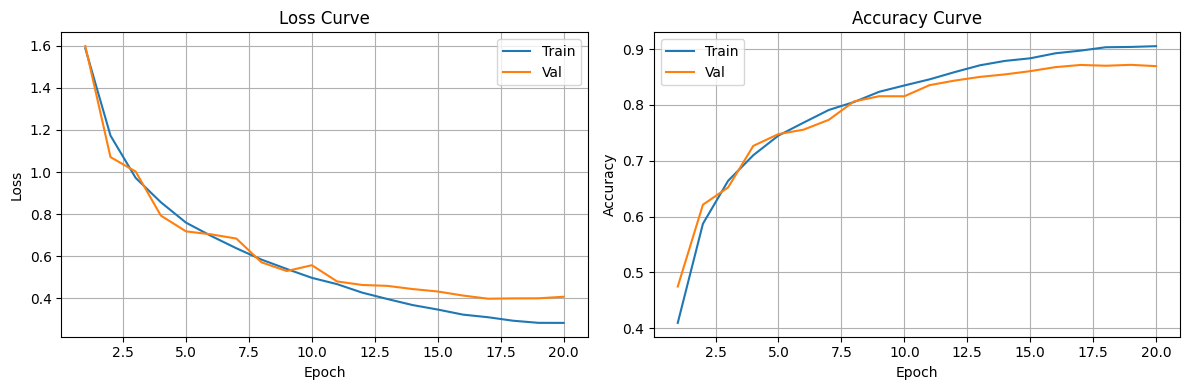

Evaluating on test set (10,000 images)...

TEST RESULTS (FP32 Baseline)
Test Accuracy: 86.94%
Average Latency: 1.296 ms
Throughput: 771.5 img/s
SCORE (Acc/Latency): 0.670701


<Figure size 1000x800 with 0 Axes>

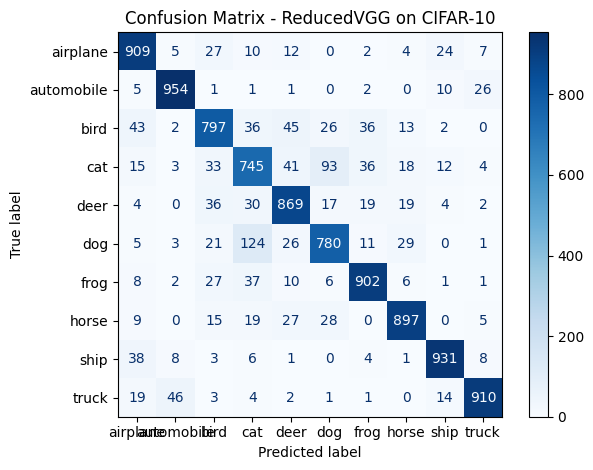

GPU COMPUTE UTILIZATION ANALYSIS

1. MODEL COMPLEXITY
   Total Parameters: 1,439,146 (1.44M)
   Total FLOPs/inference: 106,722,570 (106.72M)
   Total MACs/inference: 53,361,285 (53.36M)

2. GPU MEMORY UTILIZATION
   GPU: Tesla T4
   Total GPU Memory: 14.74 GB
   Peak Memory Used: 67.82 MB
   Memory Utilization: 0.4493%

3. THROUGHPUT vs BATCH SIZE
   Batch   1:    850.7 img/s | 1.175 ms/img | 90.79 GFLOPS
   Batch   8:   5926.6 img/s | 0.169 ms/img | 632.50 GFLOPS
   Batch  16:  11981.3 img/s | 0.083 ms/img | 1278.68 GFLOPS
   Batch  32:  24640.8 img/s | 0.041 ms/img | 2629.72 GFLOPS
   Batch  64:  26628.1 img/s | 0.038 ms/img | 2841.82 GFLOPS
   Batch 128:  26982.1 img/s | 0.037 ms/img | 2879.60 GFLOPS

4. COMPUTE EFFICIENCY
   GPU: Tesla T4
   GPU Peak (FP32): 8100 GFLOPS
   GPU Memory BW: 320 GB/s

   Peak Achieved: 2879.60 GFLOPS
   Compute Efficiency: 35.55%
   Arithmetic Intensity: 18.54 FLOPs/byte
   Ridge Point: 25.31 FLOPs/byte
   Bottleneck Type: Memory-bound

SUMMARY: GPU CO

,mode,accuracy,avg_latency_ms,score
0,W-only INT32,0.8694,1.290544,0.673669
1,W-only INT16,0.8694,1.303992,0.666722
2,W-only INT8,0.8685,1.304013,0.666021
3,W8/A16,0.8686,2.071378,0.419334
4,W32/A16,0.8694,2.073594,0.419272
5,W32/A32,0.8694,2.075694,0.418848
6,W8/A8,0.8676,2.072864,0.418551
7,W32/A8,0.8689,2.082716,0.417196
8,W16/A8,0.8686,2.089697,0.415658
9,W8/A32,0.8685,2.090983,0.415355



Best Configuration: W-only INT32
  Accuracy: 86.94%
  Latency: 1.291 ms
  Score: 0.6737

Exporting INT32 quantized weights...
Exported 60 .bin files to params_int32
Exporting INT16 quantized weights...
Exported 60 .bin files to params_int16

FINAL SUMMARY - ECE 588 FPGA Project

1. MODEL
   Architecture: ReducedVGG
   Parameters: 1,439,146
   FLOPs: 106.72M

2. GPU PERFORMANCE (FP32)
   Test Accuracy: 86.94%
   Latency: 1.296 ms
   Throughput: 771.5 img/s
   Score: 0.4186

3. GPU UTILIZATION
   GPU: Tesla T4
   Memory Used: 67.82 MB / 15095 MB (0.4493%)
   Peak GFLOPS: 2879.60
   Compute Efficiency: 35.55%
   Bottleneck: Memory-bound

4. BEST QUANTIZATION
   Config: W-only INT32
   Accuracy: 86.94%
   Latency: 1.291 ms
   Score: 0.6737

5. EXPORTED FILES
   Model checkpoint: models/reduced_vgg_best.pth
   INT32 weights: ./params_int32/
   INT16 weights: ./params_int16/

Ready for FPGA HLS implementation!


In [1]:
# =============================================================================
# ECE 588 — CIFAR-10 VGG (Complete Kaggle/Colab Notebook)
# =============================================================================
# This notebook:
# 1. Trains a ReducedVGG model on CIFAR-10
# 2. Measures latency and computes Score = Accuracy / Latency
# 3. Performs quantization experiments (INT8/INT16/INT32)
# 4. Computes GPU compute utilization metrics
# 5. Exports weights for FPGA HLS deployment
# =============================================================================

# %% [markdown]
# # ECE 588 — CIFAR-10 VGG (Complete Notebook)
# 
# This notebook adapts the MNIST/LeNet tutorial to **CIFAR-10 with a VGG-style model**, 
# adds **latency measurement**, **GPU utilization analysis**, and a **Score = Accuracy / Latency** metric.

# %% [markdown]
# ## 0. Runtime & Installs
# - Please make sure you're using a **GPU runtime**: `Runtime → Change runtime type → T4 GPU`

# %%
!pip -q install torchsummary

# %% [markdown]
# ## 1. Imports & Global Config

# %%
import os, time, math, random, json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as T

import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

# Paths
ROOT = Path('.')
MODELS_DIR = ROOT / 'models'
PARAMS_DIR = ROOT / 'params'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PARAMS_DIR.mkdir(parents=True, exist_ok=True)

# %% [markdown]
# ## 2. CIFAR-10 Dataset

# %%
BATCH_SIZE = 64

# Standard CIFAR-10 normalization
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
])
test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_set_full = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
test_set = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tfms)

# Create train/val split
val_ratio = 0.2
num_train = len(train_set_full)
num_val = int(num_train * val_ratio)
num_train_split = num_train - num_val
train_set, val_set = torch.utils.data.random_split(
    train_set_full, [num_train_split, num_val],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

classes = train_set_full.classes
print('Classes:', classes)
print(f'Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}')

# %% [markdown]
# ## 3. Model Definition: ReducedVGG

# %%
class VGGBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_convs=2):
        super().__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.ReLU(inplace=True))
            in_ch = out_ch
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class ReducedVGG(nn.Module):
    """
    A reduced VGG for CIFAR-10:
    - 4 VGG blocks with channels [32, 64, 128, 256]
    - Each block: 2x(Conv3x3 + BN + ReLU) + MaxPool
    - Classifier: FC(1024->256) + ReLU + Dropout + FC(256->10)
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            VGGBlock(3, 32),      # 32x32 -> 16x16
            VGGBlock(32, 64),     # 16x16 -> 8x8
            VGGBlock(64, 128),    # 8x8 -> 4x4
            VGGBlock(128, 256),   # 4x4 -> 2x2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create model and show summary
model = ReducedVGG(num_classes=10).to(DEVICE)
print("\nModel Architecture:")
summary(model, (3, 32, 32))

# %% [markdown]
# ## 4. Training

# %%
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


# Training setup
NUM_EPOCHS = 20
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
save_path = MODELS_DIR / 'reduced_vgg_best.pth'

print(f"\nTraining for {NUM_EPOCHS} epochs...")
print("-" * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
        }, save_path)
    
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc*100:.2f}%")

print("-" * 60)
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Model saved to: {save_path}")

# %% [markdown]
# ### 4.1 Training Curves

# %%
epochs = np.arange(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train')
plt.plot(epochs, history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train')
plt.plot(epochs, history['val_acc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 5. Test Evaluation with Latency Measurement

# %%
# Reload best checkpoint
ckpt = torch.load(save_path, map_location=DEVICE, weights_only=False)
model = ReducedVGG(num_classes=10).to(DEVICE)
model.load_state_dict(ckpt['model_state'], strict=True)
model.eval()

# Evaluate accuracy + per-sample latency
all_labels, all_preds = [], []
latencies_ms = []

# Warmup
dummy = torch.randn(1, 3, 32, 32).to(DEVICE)
with torch.no_grad():
    for _ in range(50):
        _ = model(dummy)
if torch.cuda.is_available():
    torch.cuda.synchronize()

print("Evaluating on test set (10,000 images)...")
with torch.no_grad():
    for images, labels in test_loader:
        for i in range(images.size(0)):
            img = images[i:i+1].to(DEVICE)
            lab = labels[i:i+1].to(DEVICE)

            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start = time.perf_counter()
            out = model(img)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.perf_counter()

            latencies_ms.append((end - start) * 1000.0)
            pred = out.argmax(1).item()
            all_preds.append(pred)
            all_labels.append(lab.item())

# Compute metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
avg_latency_ms = float(np.mean(latencies_ms))
score = test_acc / avg_latency_ms

print("\n" + "=" * 50)
print("TEST RESULTS (FP32 Baseline)")
print("=" * 50)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Average Latency: {avg_latency_ms:.3f} ms")
print(f"Throughput: {1000/avg_latency_ms:.1f} img/s")
print(f"SCORE (Acc/Latency): {score:.6f}")
print("=" * 50)

# %% [markdown]
# ### 5.1 Confusion Matrix

# %%
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - ReducedVGG on CIFAR-10')
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. GPU Compute Utilization Analysis
# 
# This section computes GPU resource utilization metrics for comparison with FPGA.

# %%
print("=" * 70)
print("GPU COMPUTE UTILIZATION ANALYSIS")
print("=" * 70)

# -----------------------------------------------------------------------------
# 6.1 FLOPs and Parameter Count Analysis
# -----------------------------------------------------------------------------
def count_flops_and_params(model, input_size=(1, 3, 32, 32)):
    """Count FLOPs (multiply-accumulate operations) for the model."""
    total_flops = 0
    hooks = []
    flops_list = []
    
    def conv_hook(module, input, output):
        kernel_ops = module.kernel_size[0] * module.kernel_size[1] * (module.in_channels // module.groups)
        output_elements = output.size(2) * output.size(3)
        flops = 2 * module.out_channels * output_elements * kernel_ops
        if module.bias is not None:
            flops += module.out_channels * output_elements
        flops_list.append(('conv', flops))
    
    def linear_hook(module, input, output):
        flops = 2 * module.in_features * module.out_features
        if module.bias is not None:
            flops += module.out_features
        flops_list.append(('linear', flops))
    
    def bn_hook(module, input, output):
        flops_list.append(('bn', 4 * input[0].numel()))
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(conv_hook))
        elif isinstance(module, nn.Linear):
            hooks.append(module.register_forward_hook(linear_hook))
        elif isinstance(module, nn.BatchNorm2d):
            hooks.append(module.register_forward_hook(bn_hook))
    
    dummy_input = torch.randn(input_size).to(DEVICE)
    with torch.no_grad():
        model(dummy_input)
    
    for h in hooks:
        h.remove()
    
    total_flops = sum(f[1] for f in flops_list)
    total_params = sum(p.numel() for p in model.parameters())
    return total_flops, total_params

total_flops, total_params = count_flops_and_params(model)
total_macs = total_flops // 2

print(f"\n1. MODEL COMPLEXITY")
print(f"   Total Parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"   Total FLOPs/inference: {total_flops:,} ({total_flops/1e6:.2f}M)")
print(f"   Total MACs/inference: {total_macs:,} ({total_macs/1e6:.2f}M)")

# -----------------------------------------------------------------------------
# 6.2 GPU Memory Utilization
# -----------------------------------------------------------------------------
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    
    dummy_input = torch.randn(1, 3, 32, 32).to(DEVICE)
    mem_before = torch.cuda.memory_allocated() / 1024**2
    
    with torch.no_grad():
        for _ in range(100):
            _ = model(dummy_input)
    torch.cuda.synchronize()
    
    mem_after = torch.cuda.memory_allocated() / 1024**2
    mem_peak = torch.cuda.max_memory_allocated() / 1024**2
    
    gpu_props = torch.cuda.get_device_properties(0)
    total_gpu_mem = gpu_props.total_memory / 1024**3
    
    print(f"\n2. GPU MEMORY UTILIZATION")
    print(f"   GPU: {gpu_props.name}")
    print(f"   Total GPU Memory: {total_gpu_mem:.2f} GB")
    print(f"   Peak Memory Used: {mem_peak:.2f} MB")
    print(f"   Memory Utilization: {(mem_peak / (total_gpu_mem * 1024)) * 100:.4f}%")
else:
    mem_peak = None
    total_gpu_mem = None

# -----------------------------------------------------------------------------
# 6.3 Compute Throughput Analysis
# -----------------------------------------------------------------------------
print(f"\n3. THROUGHPUT vs BATCH SIZE")

# Warmup
dummy_input = torch.randn(1, 3, 32, 32).to(DEVICE)
with torch.no_grad():
    for _ in range(50):
        _ = model(dummy_input)
if torch.cuda.is_available():
    torch.cuda.synchronize()

batch_sizes = [1, 8, 16, 32, 64, 128]
throughput_results = []

for bs in batch_sizes:
    try:
        batch_input = torch.randn(bs, 3, 32, 32).to(DEVICE)
        
        # Warmup
        with torch.no_grad():
            for _ in range(10):
                _ = model(batch_input)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        # Measure
        num_iterations = 100
        start = time.perf_counter()
        with torch.no_grad():
            for _ in range(num_iterations):
                _ = model(batch_input)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end = time.perf_counter()
        
        total_time = end - start
        images_per_sec = (bs * num_iterations) / total_time
        latency_per_image = (total_time / num_iterations / bs) * 1000
        gflops_achieved = (total_flops * bs * num_iterations) / total_time / 1e9
        
        throughput_results.append({
            'batch_size': bs,
            'throughput': images_per_sec,
            'latency_ms': latency_per_image,
            'gflops': gflops_achieved
        })
        
        print(f"   Batch {bs:3d}: {images_per_sec:8.1f} img/s | {latency_per_image:.3f} ms/img | {gflops_achieved:.2f} GFLOPS")
        
    except RuntimeError as e:
        print(f"   Batch {bs:3d}: Out of memory")
        break

# -----------------------------------------------------------------------------
# 6.4 Compute Efficiency Analysis
# -----------------------------------------------------------------------------
print(f"\n4. COMPUTE EFFICIENCY")

# GPU specs (update based on your GPU)
# Tesla T4: 8.1 TFLOPS FP32, 320 GB/s
# Tesla P100: 9.3 TFLOPS FP32, 732 GB/s
# RTX 3090: 35.6 TFLOPS FP32, 936 GB/s
GPU_SPECS = {
    'Tesla T4': {'tflops': 8.1, 'bw': 320},
    'Tesla P100-PCIE-16GB': {'tflops': 9.3, 'bw': 732},
    'NVIDIA A100-SXM4-40GB': {'tflops': 19.5, 'bw': 1555},
    'NVIDIA GeForce RTX 3090': {'tflops': 35.6, 'bw': 936},
}

if torch.cuda.is_available():
    gpu_name = gpu_props.name
    # Find matching GPU specs
    gpu_peak_tflops = 8.1  # default T4
    gpu_memory_bw = 320
    for name, specs in GPU_SPECS.items():
        if name in gpu_name:
            gpu_peak_tflops = specs['tflops']
            gpu_memory_bw = specs['bw']
            break
    
    print(f"   GPU: {gpu_name}")
    print(f"   GPU Peak (FP32): {gpu_peak_tflops * 1000:.0f} GFLOPS")
    print(f"   GPU Memory BW: {gpu_memory_bw} GB/s")

if throughput_results:
    best_result = max(throughput_results, key=lambda x: x['gflops'])
    peak_gflops = best_result['gflops']
    compute_efficiency = (peak_gflops / (gpu_peak_tflops * 1000)) * 100 if torch.cuda.is_available() else 0
    
    # Arithmetic intensity
    model_size_bytes = total_params * 4  # FP32 = 4 bytes
    arithmetic_intensity = total_flops / model_size_bytes
    
    # Roofline analysis
    if torch.cuda.is_available():
        ridge_point = (gpu_peak_tflops * 1000) / gpu_memory_bw
        bottleneck = "Memory-bound" if arithmetic_intensity < ridge_point else "Compute-bound"
    else:
        ridge_point = 0
        bottleneck = "Unknown"
    
    print(f"\n   Peak Achieved: {peak_gflops:.2f} GFLOPS")
    print(f"   Compute Efficiency: {compute_efficiency:.2f}%")
    print(f"   Arithmetic Intensity: {arithmetic_intensity:.2f} FLOPs/byte")
    print(f"   Ridge Point: {ridge_point:.2f} FLOPs/byte")
    print(f"   Bottleneck Type: {bottleneck}")

# -----------------------------------------------------------------------------
# 6.5 Summary Table
# -----------------------------------------------------------------------------
print(f"\n{'='*70}")
print("SUMMARY: GPU COMPUTE UTILIZATION")
print(f"{'='*70}")
print(f"| {'Metric':<35} | {'Value':<28} |")
print(f"|{'-'*37}|{'-'*30}|")
print(f"| {'Total Parameters':<35} | {total_params:,} |")
print(f"| {'Total FLOPs/inference':<35} | {total_flops/1e6:.2f} MFLOPs |")
print(f"| {'Total MACs/inference':<35} | {total_macs/1e6:.2f} MMACs |")
if torch.cuda.is_available() and mem_peak:
    print(f"| {'GPU Memory (Total)':<35} | {total_gpu_mem:.2f} GB |")
    print(f"| {'Peak Memory Used':<35} | {mem_peak:.2f} MB |")
    print(f"| {'Memory Utilization':<35} | {(mem_peak / (total_gpu_mem * 1024)) * 100:.4f}% |")
if throughput_results:
    best_batch1 = next((r for r in throughput_results if r['batch_size'] == 1), throughput_results[0])
    print(f"| {'Latency (batch=1)':<35} | {best_batch1['latency_ms']:.3f} ms |")
    print(f"| {'Throughput (batch=1)':<35} | {best_batch1['throughput']:.1f} img/s |")
    print(f"| {'Peak GFLOPS Achieved':<35} | {peak_gflops:.2f} GFLOPS |")
    print(f"| {'Compute Efficiency':<35} | {compute_efficiency:.2f}% |")
    print(f"| {'Arithmetic Intensity':<35} | {arithmetic_intensity:.2f} FLOPs/byte |")
    print(f"| {'Bottleneck':<35} | {bottleneck} |")
print(f"{'='*70}")

# Store results
gpu_compute_utilization = {
    'platform': f'GPU ({gpu_props.name})' if torch.cuda.is_available() else 'CPU',
    'total_params': total_params,
    'total_flops': total_flops,
    'total_macs': total_macs,
    'peak_memory_mb': mem_peak,
    'total_gpu_mem_gb': total_gpu_mem,
    'latency_ms': best_batch1['latency_ms'] if throughput_results else None,
    'throughput_img_s': best_batch1['throughput'] if throughput_results else None,
    'peak_gflops': peak_gflops if throughput_results else None,
    'compute_efficiency_pct': compute_efficiency if throughput_results else None,
    'arithmetic_intensity': arithmetic_intensity if throughput_results else None,
    'bottleneck': bottleneck if throughput_results else None,
}

# %% [markdown]
# ## 7. Quantization Experiments
# 
# We evaluate INT8, INT16, and INT32 quantization for weights and activations.

# %%
# -----------------------------------------------------------------------------
# Quantization Utilities
# -----------------------------------------------------------------------------

def _qparams_symmetric_per_tensor(t: torch.Tensor, bits: int):
    qmax = (1 << (bits - 1)) - 1
    max_abs = t.abs().max()
    scale = (max_abs / qmax) if max_abs > 0 else torch.tensor(1.0, device=t.device, dtype=t.dtype)
    return scale, qmax

def quantize_dequantize_tensor(t: torch.Tensor, bits: int):
    scale, qmax = _qparams_symmetric_per_tensor(t, bits)
    q = torch.clamp(torch.round(t / scale), min=-qmax-1, max=qmax)
    return (q * scale).to(t.dtype)

@torch.no_grad()
def quantize_model_weights(model: torch.nn.Module, bits: int):
    """Weight-only quantization."""
    qmodel = deepcopy(model)
    for n, m in qmodel.named_modules():
        if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
            m.weight.copy_(quantize_dequantize_tensor(m.weight, bits))
    return qmodel

class ActCalibrator(torch.nn.Module):
    """Activation calibration for quantization."""
    def __init__(self, model, modules_to_calib=(torch.nn.Conv2d, torch.nn.Linear)):
        super().__init__()
        self.model = model
        self.handles = []
        self.act_max = {}
        
        def hook(name):
            def _fn(_m, _in, out):
                with torch.no_grad():
                    max_abs = out.detach().abs().max().item()
                    self.act_max[name] = max(self.act_max.get(name, 0.0), max_abs)
            return _fn
        
        for name, m in self.model.named_modules():
            if isinstance(m, modules_to_calib):
                self.handles.append(m.register_forward_hook(hook(name)))
    
    def forward(self, x):
        return self.model(x)
    
    def remove_hooks(self):
        for h in self.handles:
            h.remove()

def calibrate_activations(model, loader, device, num_batches=50):
    """Run calibration to find activation ranges."""
    calib = ActCalibrator(model)
    calib.to(device)
    calib.eval()
    
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break
            images = images.to(device)
            calib(images)
    
    act_max = calib.act_max.copy()
    calib.remove_hooks()
    return act_max

class QuantizedModel(torch.nn.Module):
    """Model with quantized weights and activations."""
    def __init__(self, model, w_bits, a_bits, act_max):
        super().__init__()
        self.model = deepcopy(model)
        self.a_bits = a_bits
        self.act_max = act_max
        
        # Quantize weights
        for n, m in self.model.named_modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
                m.weight.data = quantize_dequantize_tensor(m.weight.data, w_bits)
        
        # Register hooks for activation quantization
        self.handles = []
        for name, m in self.model.named_modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
                if name in self.act_max:
                    self.handles.append(
                        m.register_forward_hook(self._make_quant_hook(name))
                    )
    
    def _make_quant_hook(self, name):
        max_val = self.act_max[name]
        bits = self.a_bits
        qmax = (1 << (bits - 1)) - 1
        scale = max_val / qmax if max_val > 0 else 1.0
        
        def hook(module, input, output):
            q = torch.clamp(torch.round(output / scale), -qmax-1, qmax)
            return q * scale
        return hook
    
    def forward(self, x):
        return self.model(x)

def evaluate_quantized(model, loader, device):
    """Evaluate quantized model with latency measurement."""
    model.eval()
    model.to(device)
    
    correct, total = 0, 0
    latencies = []
    
    # Warmup
    dummy = torch.randn(1, 3, 32, 32).to(device)
    with torch.no_grad():
        for _ in range(20):
            _ = model(dummy)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    with torch.no_grad():
        for images, labels in loader:
            for i in range(images.size(0)):
                img = images[i:i+1].to(device)
                lab = labels[i].item()
                
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                start = time.perf_counter()
                out = model(img)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                end = time.perf_counter()
                
                latencies.append((end - start) * 1000)
                pred = out.argmax(1).item()
                if pred == lab:
                    correct += 1
                total += 1
    
    acc = correct / total
    avg_lat = np.mean(latencies)
    return acc, avg_lat

# %%
# -----------------------------------------------------------------------------
# Run Quantization Experiments
# -----------------------------------------------------------------------------
print("=" * 70)
print("QUANTIZATION EXPERIMENTS")
print("=" * 70)

# Calibrate activations
print("\nCalibrating activations...")
act_max = calibrate_activations(model, train_loader, DEVICE, num_batches=50)
print(f"Calibrated {len(act_max)} layers")

# Weight-only quantization
print("\n--- Weight-Only Quantization ---")
ptq_weight_results = []

for bits in [32, 16, 8]:
    print(f"Testing W-only INT{bits}...", end=" ")
    qmodel = quantize_model_weights(deepcopy(model).to(DEVICE), bits)
    acc, lat = evaluate_quantized(qmodel, test_loader, DEVICE)
    score = acc / lat
    ptq_weight_results.append({
        'mode': f'W-only INT{bits}',
        'accuracy': acc,
        'avg_latency_ms': lat,
        'score': score
    })
    print(f"Acc: {acc*100:.2f}%, Lat: {lat:.3f}ms, Score: {score:.4f}")

# Weight + Activation quantization
print("\n--- Weight + Activation Quantization ---")
ptq_wa_results = []

for w_bits in [32, 16, 8]:
    for a_bits in [32, 16, 8]:
        print(f"Testing W{w_bits}/A{a_bits}...", end=" ")
        qmodel = QuantizedModel(model, w_bits, a_bits, act_max).to(DEVICE)
        acc, lat = evaluate_quantized(qmodel, test_loader, DEVICE)
        score = acc / lat
        ptq_wa_results.append({
            'mode': f'W{w_bits}/A{a_bits}',
            'accuracy': acc,
            'avg_latency_ms': lat,
            'score': score
        })
        print(f"Acc: {acc*100:.2f}%, Lat: {lat:.3f}ms, Score: {score:.4f}")

# %%
# -----------------------------------------------------------------------------
# Display Results Table
# -----------------------------------------------------------------------------
import pandas as pd

all_results = ptq_weight_results + ptq_wa_results
df = pd.DataFrame(all_results)
df_sorted = df.sort_values('score', ascending=False).reset_index(drop=True)

print("\n" + "=" * 70)
print("QUANTIZATION RESULTS (Sorted by Score)")
print("=" * 70)
display(df_sorted)

# Best configuration
best = df_sorted.iloc[0]
print(f"\nBest Configuration: {best['mode']}")
print(f"  Accuracy: {best['accuracy']*100:.2f}%")
print(f"  Latency: {best['avg_latency_ms']:.3f} ms")
print(f"  Score: {best['score']:.4f}")

# %% [markdown]
# ## 8. Export Weights for FPGA

# %%
def export_model_bins(model_any, out_dir: Path, dtype=np.float32):
    """Export model weights to binary files for HLS."""
    out_dir.mkdir(parents=True, exist_ok=True)
    with torch.no_grad():
        for name, t in model_any.state_dict().items():
            arr = t.detach().cpu().numpy().astype(dtype)
            filename = name.replace('.', '_') + '.bin'
            (out_dir / filename).write_bytes(arr.tobytes())
    print(f"Exported {len(list(out_dir.glob('*.bin')))} .bin files to {out_dir}")

# Export INT32 quantized model (recommended for FPGA)
print("\nExporting INT32 quantized weights...")
best_qmodel = quantize_model_weights(deepcopy(model).to(DEVICE), bits=32)
export_model_bins(best_qmodel, Path("./params_int32"), dtype=np.float32)

# Also export INT16 version
print("Exporting INT16 quantized weights...")
qmodel_int16 = quantize_model_weights(deepcopy(model).to(DEVICE), bits=16)
export_model_bins(qmodel_int16, Path("./params_int16"), dtype=np.float32)

# %% [markdown]
# ## 9. Final Summary

# %%
print("\n" + "=" * 70)
print("FINAL SUMMARY - ECE 588 FPGA Project")
print("=" * 70)

print("\n1. MODEL")
print(f"   Architecture: ReducedVGG")
print(f"   Parameters: {total_params:,}")
print(f"   FLOPs: {total_flops/1e6:.2f}M")

print("\n2. GPU PERFORMANCE (FP32)")
print(f"   Test Accuracy: {test_acc*100:.2f}%")
print(f"   Latency: {avg_latency_ms:.3f} ms")
print(f"   Throughput: {1000/avg_latency_ms:.1f} img/s")
print(f"   Score: {score:.4f}")

print("\n3. GPU UTILIZATION")
if torch.cuda.is_available():
    print(f"   GPU: {gpu_props.name}")
    print(f"   Memory Used: {mem_peak:.2f} MB / {total_gpu_mem*1024:.0f} MB ({(mem_peak/(total_gpu_mem*1024))*100:.4f}%)")
if throughput_results:
    print(f"   Peak GFLOPS: {peak_gflops:.2f}")
    print(f"   Compute Efficiency: {compute_efficiency:.2f}%")
    print(f"   Bottleneck: {bottleneck}")

print("\n4. BEST QUANTIZATION")
print(f"   Config: {best['mode']}")
print(f"   Accuracy: {best['accuracy']*100:.2f}%")
print(f"   Latency: {best['avg_latency_ms']:.3f} ms")
print(f"   Score: {best['score']:.4f}")

print("\n5. EXPORTED FILES")
print(f"   Model checkpoint: {save_path}")
print(f"   INT32 weights: ./params_int32/")
print(f"   INT16 weights: ./params_int16/")

print("\n" + "=" * 70)
print("Ready for FPGA HLS implementation!")
print("=" * 70)